<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/%EA%B7%9C%EC%88%9C/%20Preprocess_v3_%EC%A0%81%EC%9A%A9_LSTM%2C_TranAD%2C_1D_ResNet_%EC%9E%AC%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#1 드라이브 연결
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#실험 별로 나누어서 데이터셋 구성
# ==========================================
# 1. 라이브러리 및 환경 설정 (필수)
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import warnings


# ==========================================
# 2. 데이터 로드
# ==========================================
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수
# ==========================================
"""
    Wafer_ID 별로 슬라이딩 윈도우를 적용하고,
    각 윈도우가 어떤 Wafer에 속하는지 ID 리스트를 함께 반환합니다.
"""
def create_sequences_with_ids(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 데이터 추출
    data_values = df_target[sensor_cols].values

    # 2. 스케일링 (Train 통계로만 Scale)
    if is_train:
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler from training data.")
        data_scaled = scaler.transform(data_values)

    # 스케일링된 데이터를 다시 DataFrame으로 매핑 (ID 그룹핑 용도)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences = []
    all_wafer_ids = [] # [NEW] 각 윈도우의 소스 Wafer ID를 저장할 리스트

    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터 길이가 윈도우보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            window = wafer_data[i : i + seq_len]

            all_sequences.append(window)
            all_wafer_ids.append(wafer) # [NEW] 현재 윈도우의 Wafer ID 저장

    if len(all_sequences) == 0:
        return np.array([]), np.array([]), scaler

    return np.array(all_sequences), np.array(all_wafer_ids), scaler

# ==========================================
# 4. 데이터셋 구성 및 저장
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}
SEQ_LEN = 32

# 학습 데이터 비율 설정
TRAIN_RATIO = 0.6

print(f"\n--- Preprocessing Data (Train Ratio: {TRAIN_RATIO*100}%) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 실험 데이터 필터링
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
    if exp_df.empty:
        continue

    # 2. Train / Test Split (Wafer ID 기준)
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    # [수정] 비율 적용 (Normal Wafer만 분할)
    n_train = int(len(normal_wafer_ids) * TRAIN_RATIO)

    train_ids = normal_wafer_ids[:n_train]
    test_norm_ids = normal_wafer_ids[n_train:]

    # ID 기반 데이터프레임 분할
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    print(f"  - Total Normal: {len(normal_wafer_ids)}")
    print(f"  -> Train Normal : {len(train_ids)} ({TRAIN_RATIO*100:.0f}%)")
    print(f"  -> Test Normal  : {len(test_norm_ids)} ({(1-TRAIN_RATIO)*100:.0f}%)")
    print(f"  -> Test Fault   : {len(fault_wafer_ids)} (100%)")

    # 3. 시퀀스 생성 (X, Wafer_ID 반환)
    # (1) Train: Scaler 학습 (Fit)
    X_train, y_train_ids, scaler = create_sequences_with_ids(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal: Scaler 적용 (Transform)
    X_test_norm, y_test_norm_ids, _ = create_sequences_with_ids(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False
    )

    # (3) Test Fault: Scaler 적용 (Transform)
    if not test_fault_df.empty:
        X_test_fault, y_test_fault_ids, _ = create_sequences_with_ids(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False
        )
    else:
        X_test_fault, y_test_fault_ids = np.array([]), np.array([])

    # 4. Dictionary에 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_norm,
        'X_test_fault': X_test_fault,
        'ids_train': y_train_ids,
        'ids_test_norm': y_test_norm_ids,
        'ids_test_fault': y_test_fault_ids,
        'scaler': scaler
    }

print("\n✅ Data preprocessing with new ratio completed.")

Loading data from: /content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx

--- Preprocessing Data (Train Ratio: 60.0%) ---

Processing Experiment: l29
  - Total Normal: 34
  -> Train Normal : 20 (60%)
  -> Test Normal  : 14 (40%)
  -> Test Fault   : 9 (100%)

Processing Experiment: l31
  - Total Normal: 37
  -> Train Normal : 22 (60%)
  -> Test Normal  : 15 (40%)
  -> Test Fault   : 6 (100%)

Processing Experiment: l33
  - Total Normal: 37
  -> Train Normal : 22 (60%)
  -> Test Normal  : 15 (40%)
  -> Test Fault   : 6 (100%)

✅ Data preprocessing with new ratio completed.


In [3]:
# ==========================================
# 3. 유틸리티 함수 (데이터 로드, 집계, 시각화)
# ==========================================
def get_data_loaders(exp_id, datasets_dict, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")
    data = datasets_dict[exp_id]

    # 데이터 추출
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    ids_test_norm = data['ids_test_norm']
    X_test_fault = data['X_test_fault']
    ids_test_fault = data['ids_test_fault']

    # Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # DataLoader (Train only)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault)

def aggregate_wafer_scores(window_scores, wafer_ids, method='max'):
    # DataFrame핑하여 GroupBy 연산
    df_temp = pd.DataFrame({'Wafer_ID': wafer_ids, 'Score': window_scores})

    if method == 'max':
        grouped = df_temp.groupby('Wafer_ID')['Score'].max()
    else:
        grouped = df_temp.groupby('Wafer_ID')['Score'].mean()

    return grouped.index.values, grouped.values

def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance (Wafer-Level)", fontsize=16, fontweight='bold')

    # Confusion Matrix
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    axes[0].set_title("Confusion Matrix")

    # Scatter Plot (Wafer Scores)
    normal_idx = np.where(labels == 0)[0]
    fault_idx = np.where(labels == 1)[0]

    axes[1].scatter(normal_idx, scores[normal_idx], color='blue', label='Normal', alpha=0.6, s=20)
    axes[1].scatter(fault_idx, scores[fault_idx], color='red', label='Fault', alpha=0.6, s=20)
    axes[1].axhline(y=threshold, color='green', linestyle='--', label='Threshold')
    axes[1].set_title("Wafer Anomaly Scores")
    axes[1].legend()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def evaluate_performance(model_name, exp_id, scores, labels):
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Wafer-Level Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1

In [4]:
# ==========================================
# 4. 모델 클래스 정의
# ==========================================

# (1) LSTM AutoEncoder
class LSTM_AE(nn.Module):
    def __init__(self, n_features, seq_len, hidden_dim=64):
        super(LSTM_AE, self).__init__()
        self.seq_len = seq_len
        self.encoder = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, n_features, batch_first=True)

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        h_repeated = h.permute(1, 0, 2).repeat(1, self.seq_len, 1)
        out, _ = self.decoder(h_repeated)
        return out

# (2) TranAD (Simplified)
class TranAD(nn.Module):
    def __init__(self, n_feats, seq_len, d_model=64):
        super(TranAD, self).__init__()
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.input_proj = nn.Linear(n_feats, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=8, num_encoder_layers=1,
            num_decoder_layers=1, batch_first=True
        )
        self.output_proj = nn.Linear(d_model, n_feats)

    def forward(self, x):
        src = self.input_proj(x) + self.pos_encoder
        out = self.transformer(src, src)
        return self.output_proj(out)

# (3) 1D ResNet (Supervised Classification)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, n_features):
        super(ResNet1D, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.block1 = ResidualBlock(64, 64)
        self.block2 = ResidualBlock(64, 128, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)
    def forward(self, x):
        x = x.transpose(1, 2)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.avg_pool(out).squeeze(-1)
        return torch.sigmoid(self.fc(out))

✅ Using device: cpu

📊 [Data Setup] Experiment: l29

🚀 [Processing] Model: LSTM-AE | Exp: l29

📌 [LSTM-AE - l29] Wafer-Level Summary
   - AUROC         : 0.7698
   - Best F1-Score : 0.7000
   - Best Threshold: 0.043006


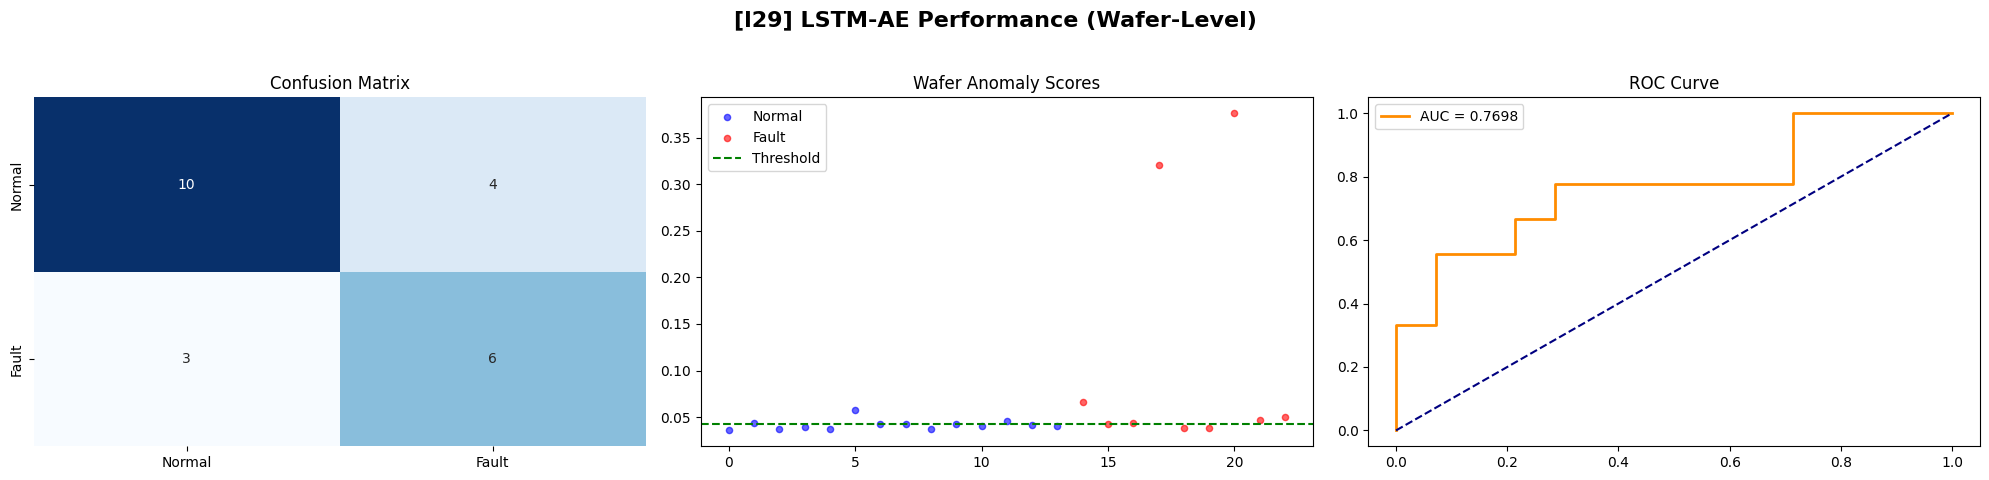


🚀 [Processing] Model: TranAD | Exp: l29

📌 [TranAD - l29] Wafer-Level Summary
   - AUROC         : 0.8889
   - Best F1-Score : 0.8235
   - Best Threshold: 0.009210


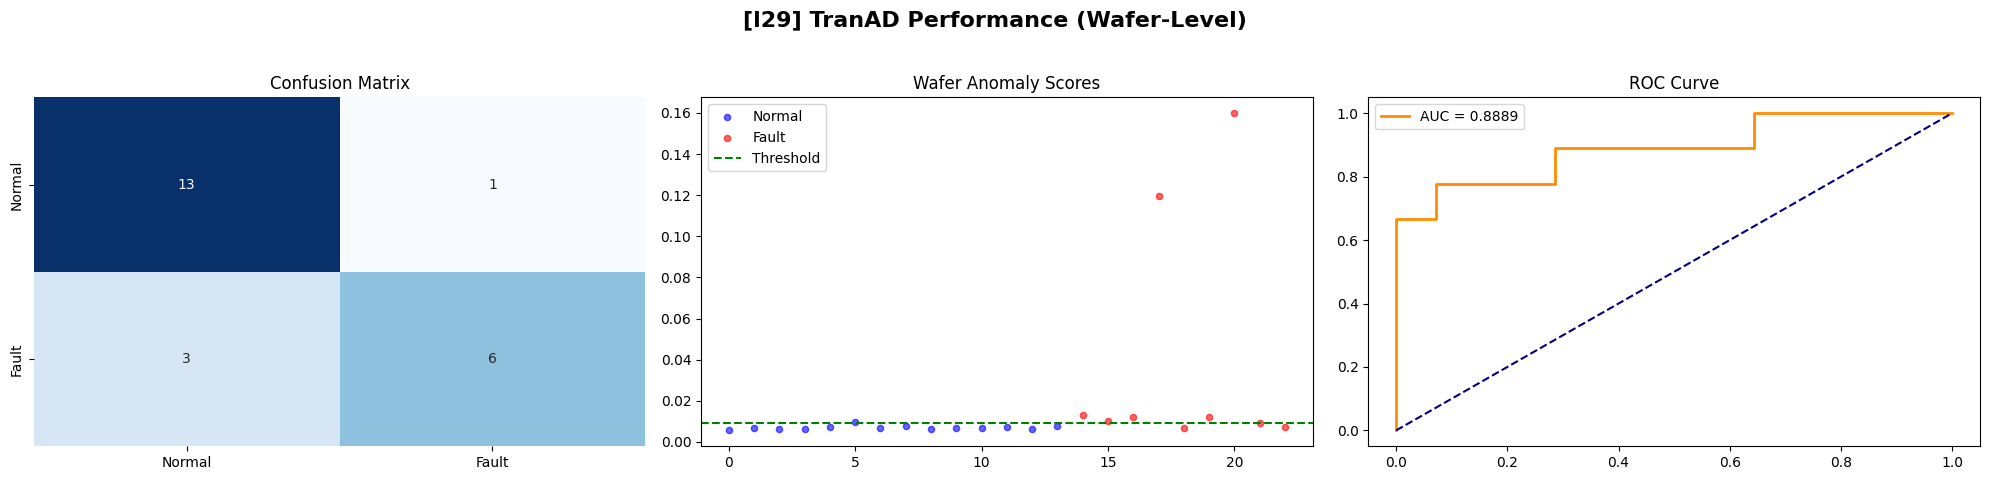


🚀 [Processing] Model: 1D-ResNet | Exp: l29

📌 [1D-ResNet - l29] Wafer-Level Summary
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 0.999977


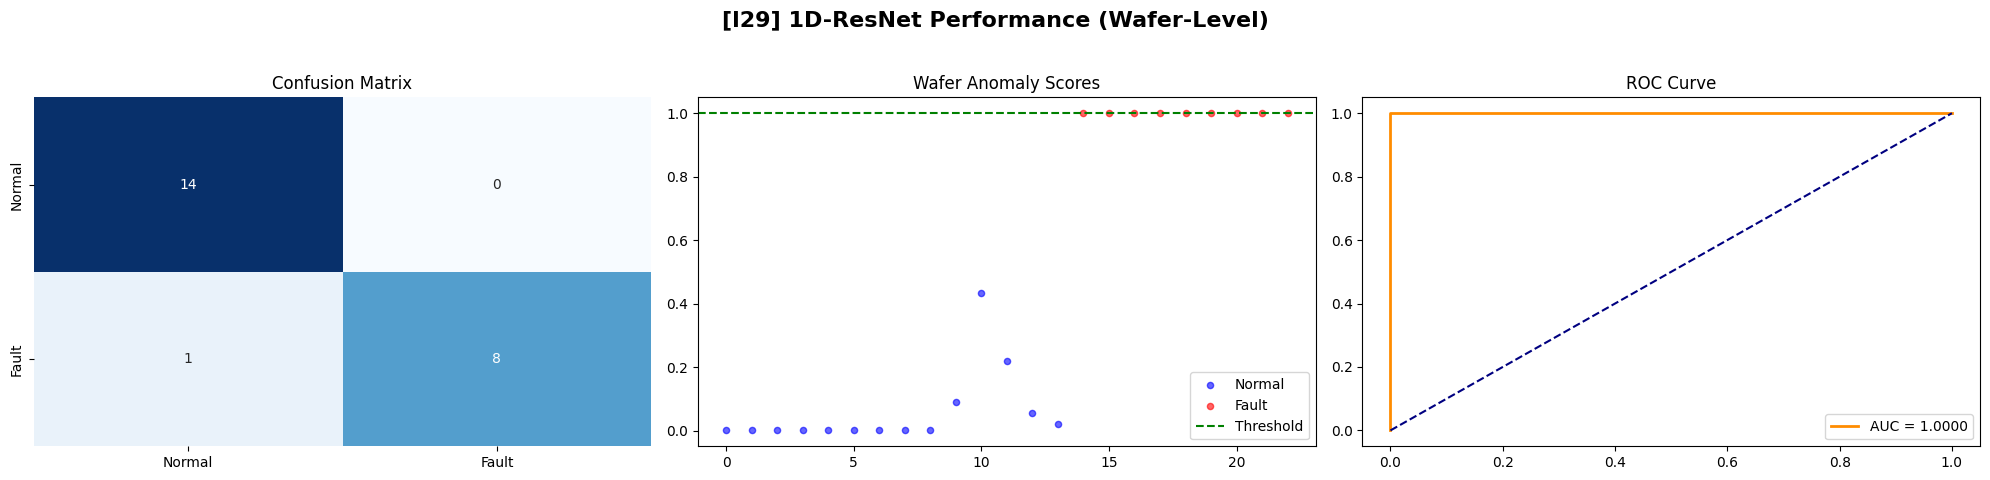


📊 [Data Setup] Experiment: l31

🚀 [Processing] Model: LSTM-AE | Exp: l31

📌 [LSTM-AE - l31] Wafer-Level Summary
   - AUROC         : 0.9667
   - Best F1-Score : 0.8571
   - Best Threshold: 0.035197


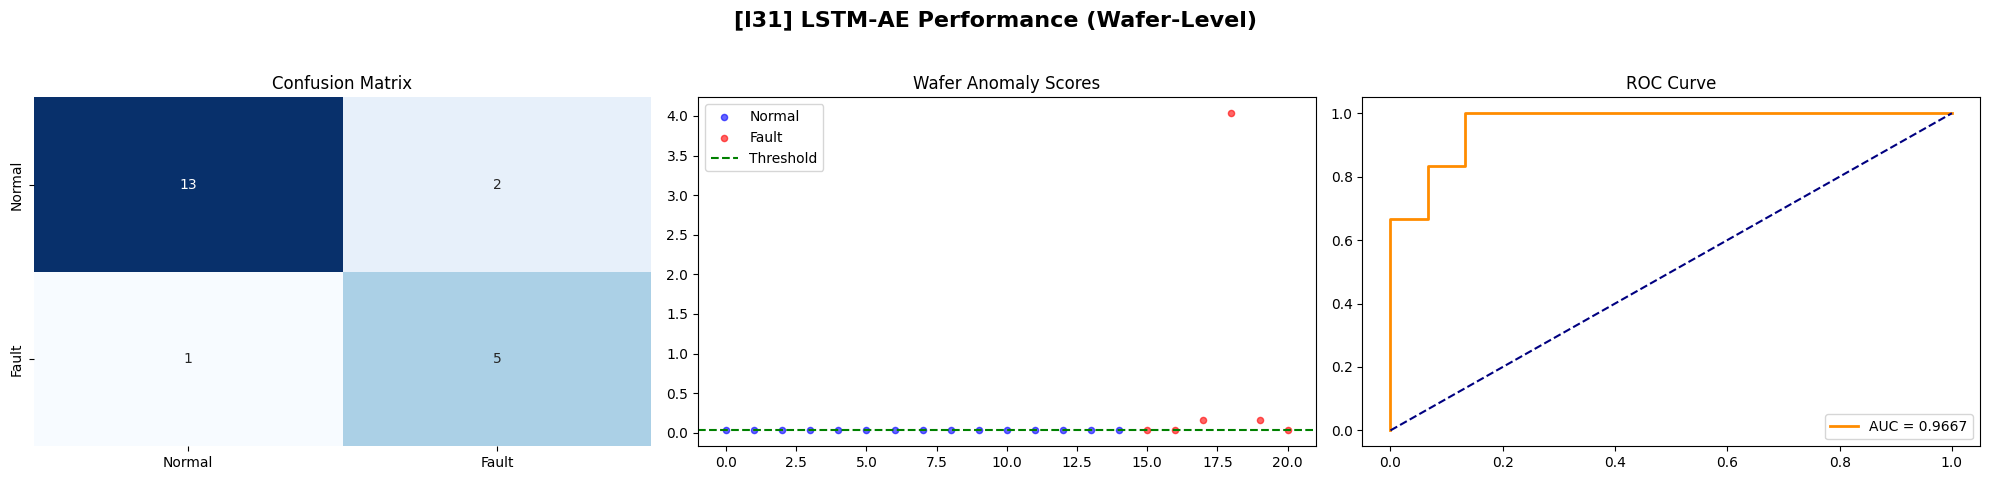


🚀 [Processing] Model: TranAD | Exp: l31

📌 [TranAD - l31] Wafer-Level Summary
   - AUROC         : 0.9333
   - Best F1-Score : 0.9091
   - Best Threshold: 0.008230


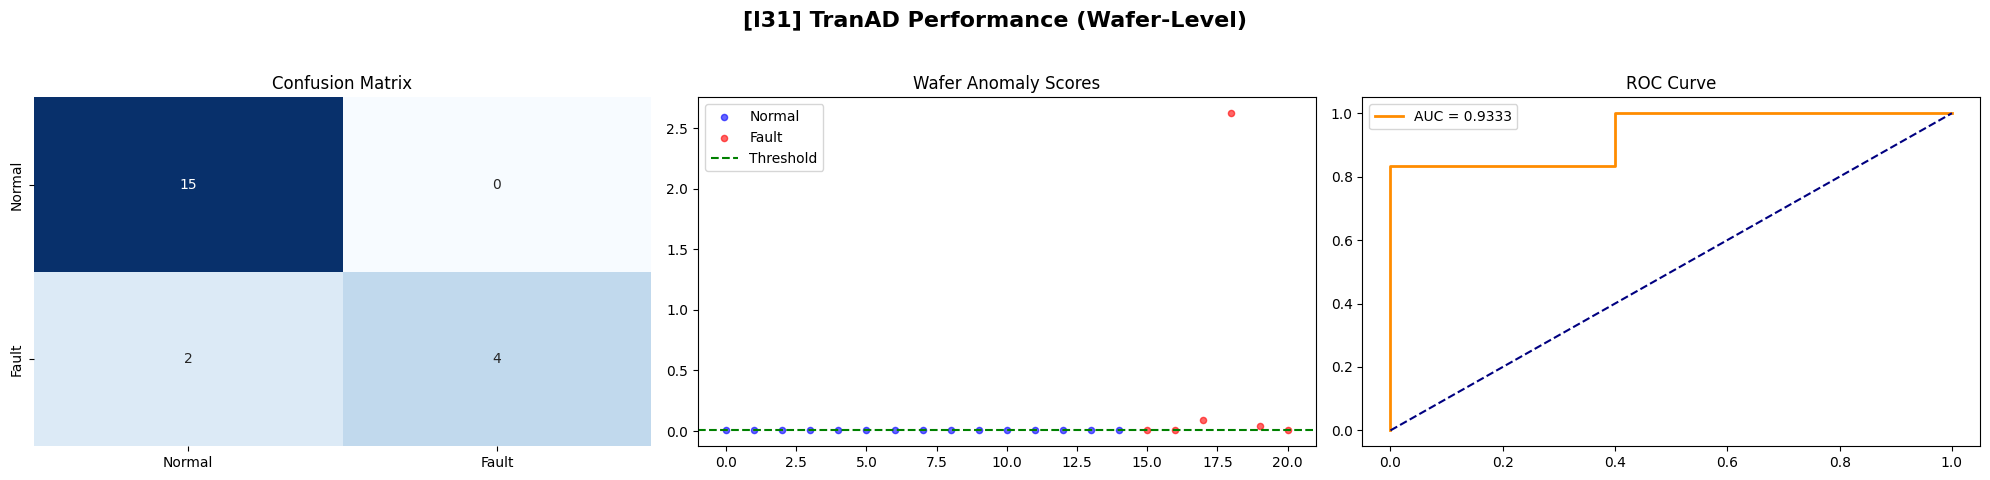


🚀 [Processing] Model: 1D-ResNet | Exp: l31

📌 [1D-ResNet - l31] Wafer-Level Summary
   - AUROC         : 0.9111
   - Best F1-Score : 0.8571
   - Best Threshold: 0.999031


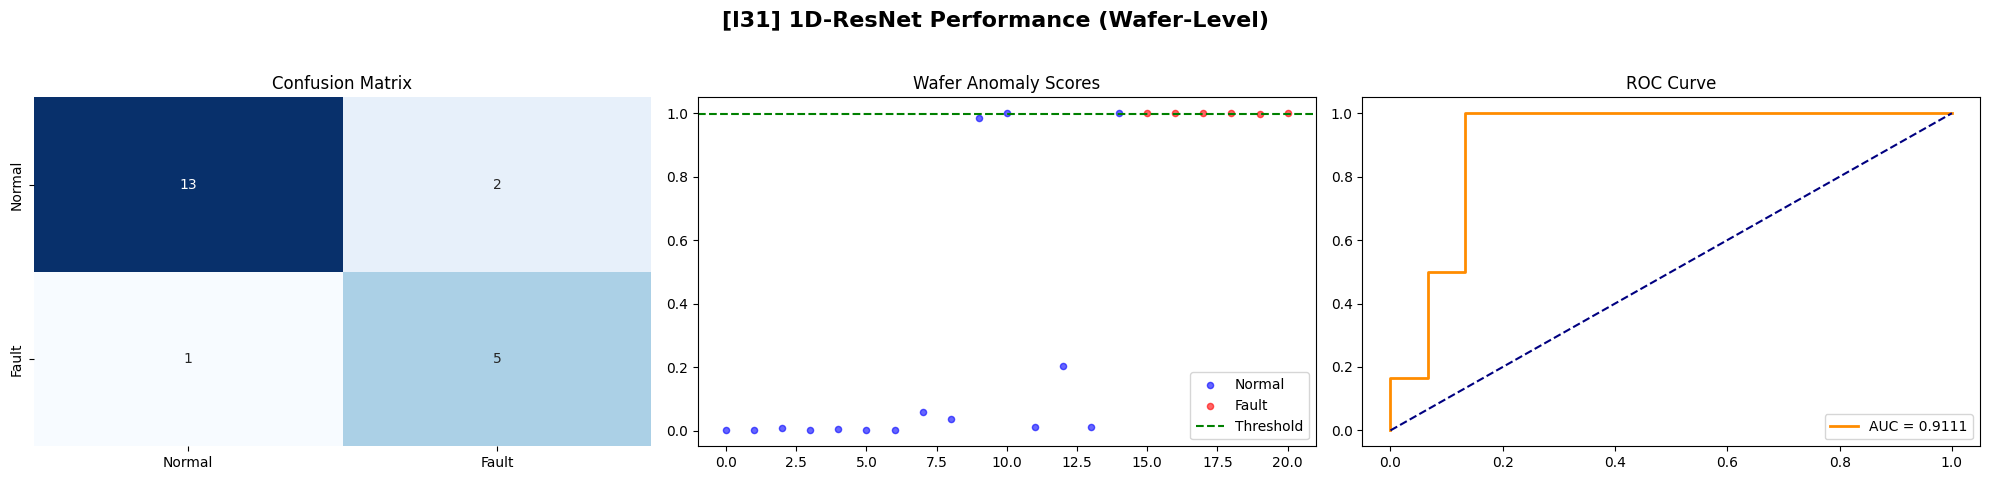


📊 [Data Setup] Experiment: l33

🚀 [Processing] Model: LSTM-AE | Exp: l33

📌 [LSTM-AE - l33] Wafer-Level Summary
   - AUROC         : 0.7333
   - Best F1-Score : 0.7273
   - Best Threshold: 0.041563


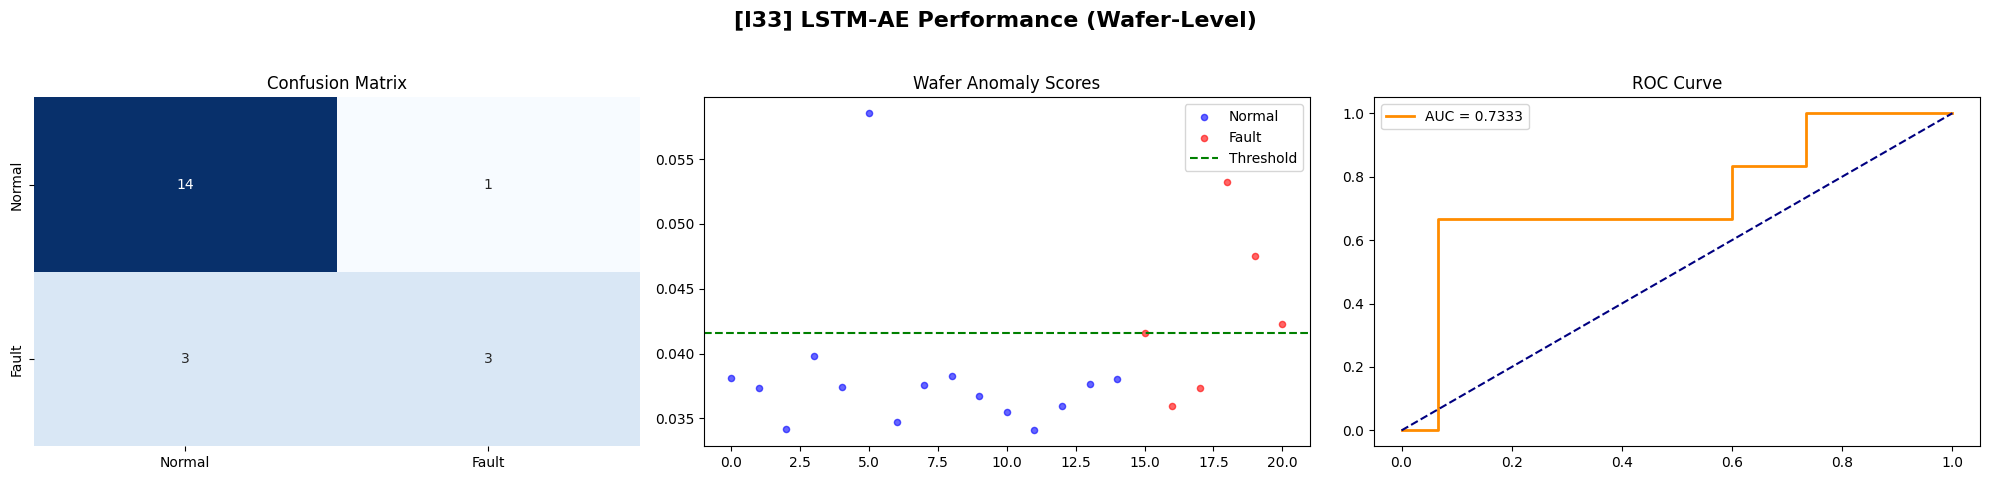


🚀 [Processing] Model: TranAD | Exp: l33

📌 [TranAD - l33] Wafer-Level Summary
   - AUROC         : 0.8111
   - Best F1-Score : 0.7059
   - Best Threshold: 0.006671


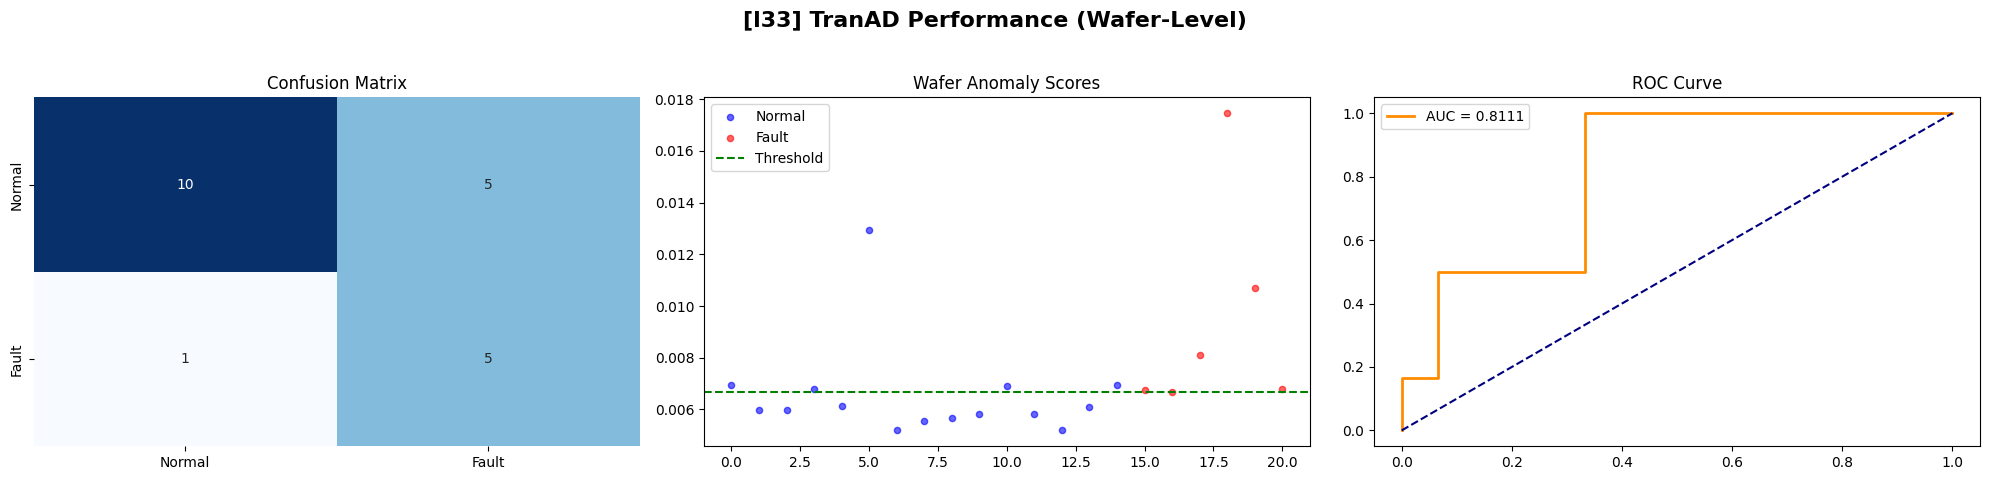


🚀 [Processing] Model: 1D-ResNet | Exp: l33

📌 [1D-ResNet - l33] Wafer-Level Summary
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 0.999945


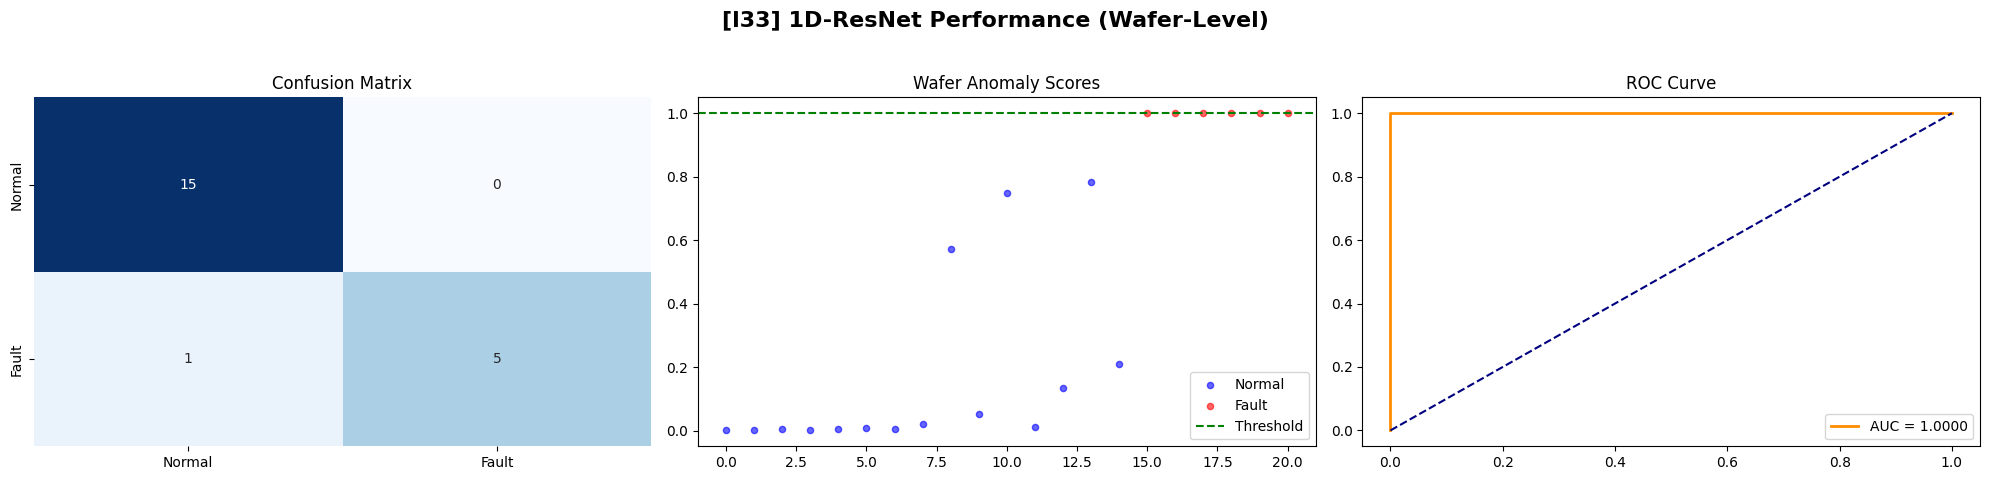


✅ All experiments for all models are finished.


In [6]:
# ==========================================
# 5. 환경 설정 및 장치 정의
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# device 선언이 루프 바깥 혹은 상단에 반드시 있어야 합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 하이퍼파라미터
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# 실험 대상
target_experiments = ['l29', 'l31', 'l33']

# ==========================================
# 6. 메인 실행 루프
# ==========================================
for exp_id in target_experiments:
    if exp_id not in datasets:
        print(f"Skipping {exp_id}: Dataset not found.")
        continue

    # 데이터 로더 준비 (사용자 정의 get_data_loaders 활용)
    # 내부에서 'device' 변수를 참조하므로 위에서 선언된 device가 사용됩니다.
    train_loader, (test_norm, ids_norm), (test_fault, ids_fault) = get_data_loaders(exp_id, datasets, BATCH_SIZE)

    n_features = test_norm.shape[2]
    seq_len = test_norm.shape[1]

    # 모델 리스트 정의
    model_configs = [
        ("LSTM-AE", lambda: LSTM_AE(n_features, seq_len).to(device), False),
        ("TranAD", lambda: TranAD(n_features, seq_len).to(device), False),
        ("1D-ResNet", lambda: ResNet1D(n_features).to(device), True)
    ]

    for m_name, m_factory, is_supervised in model_configs:
        print(f"\n🚀 [Processing] Model: {m_name} | Exp: {exp_id}")

        model = m_factory() # 위에서 .to(device) 포함됨
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # --- 학습 (Training) ---
        if not is_supervised:
            # 비지도 학습 (AE, TranAD)
            criterion = nn.MSELoss()
            model.train()
            for epoch in range(NUM_EPOCHS):
                for (batch_x,) in train_loader:
                    batch_x = batch_x.to(device) # 안전하게 장치 이동
                    optimizer.zero_grad()
                    recon = model(batch_x)
                    loss = criterion(recon, batch_x)
                    loss.backward()
                    optimizer.step()
        else:
            # 지도 학습 (1D-ResNet)
            criterion = nn.BCELoss()
            # 소량의 Fault와 Normal 데이터를 섞어 학습 (전처리에 맞춰 수정)
            f_len = len(test_fault)
            if f_len > 0:
                X_sup = torch.cat([test_norm[:f_len], test_fault], dim=0).to(device)
                Y_sup = torch.cat([torch.zeros(f_len), torch.ones(f_len)], dim=0).to(device)
                sup_loader = DataLoader(TensorDataset(X_sup, Y_sup), batch_size=BATCH_SIZE, shuffle=True)

                model.train()
                for epoch in range(NUM_EPOCHS):
                    for bx, by in sup_loader:
                        optimizer.zero_grad()
                        pred = model(bx).squeeze()
                        loss = criterion(pred, by)
                        loss.backward()
                        optimizer.step()

        # --- 추론 및 웨이퍼 집계 (Inference) ---
        model.eval()
        with torch.no_grad():
            if not is_supervised:
                # Reconstruction Error 기반 점수
                score_n = torch.mean((model(test_norm) - test_norm)**2, dim=[1,2]).cpu().numpy()
                if len(test_fault) > 0:
                    score_f = torch.mean((model(test_fault) - test_fault)**2, dim=[1,2]).cpu().numpy()
                else:
                    score_f = np.array([])
            else:
                # 분류 확률 기반 점수
                score_n = model(test_norm).cpu().numpy().flatten()
                score_f = model(test_fault).cpu().numpy().flatten() if len(test_fault) > 0 else np.array([])

        # 웨이퍼 단위 Max 집계
        _, w_score_n = aggregate_wafer_scores(score_n, ids_norm, method='max')
        if len(score_f) > 0:
            _, w_score_f = aggregate_wafer_scores(score_f, ids_fault, method='max')
        else:
            w_score_f = np.array([])

        final_scores = np.concatenate([w_score_n, w_score_f])
        final_labels = np.concatenate([np.zeros(len(w_score_n)), np.ones(len(w_score_f))])

        # 평가 및 시각화 (사용자 정의 함수 호출)
        evaluate_performance(m_name, exp_id, final_scores, final_labels)

print("\n✅ All experiments for all models are finished.")